In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida (archivo class_09.csv), obtenga el modelo estimado usando el modelo ARMAX.

**Paso 1: Lectura de los datos**

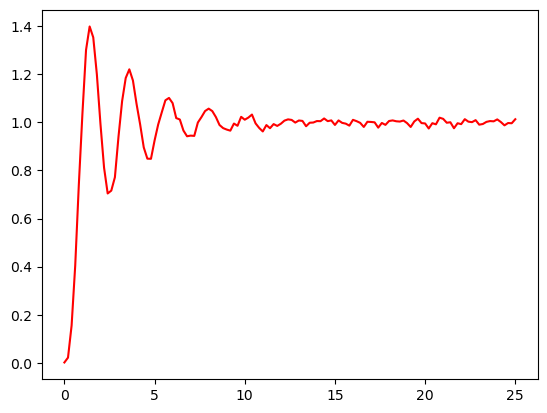

In [2]:
datos = pd.read_csv ('data\clase_09.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un
plt.plot(t,yn,color = 'red')
dt = (t[1]-t[0])
dt

## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3]]$$

In [3]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran

y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

In [4]:
## Creación del vector phi
phi = np.array([-y_1,-y_2,-y_3,u_1]).transpose()

## Definición de matriz de pesos para dar mayor peso al transitorio
pesos = np.zeros(N)
for k in range(0,N):
    pesos[k]=1

W = np.eye(N)*pesos.transpose()
_phi = np.dot(W,phi)
_yn = np.dot(W,yn)

In [5]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 1e-9
A = np.dot(_phi.T,_phi) + alpha*np.eye(len(np.dot(_phi.T,_phi)))
theta = np.dot(np.linalg.inv(A),np.dot(_phi.T,_yn))
theta

array([-1.70873201,  0.96858804, -0.10781648,  0.1504624 ])

In [6]:
dfReg = pd.DataFrame(data={'y':yn,'y_1':y_1,'y_2':y_2,'y_3':y_3,'u_1':u_1,'u_2':u_2,'u_3':u_3})
#sns.pairplot(dfReg)

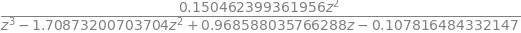

In [7]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2 + theta[2]*z**-3 
B =  theta[3]*z**-1
## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.

In [8]:
## Función de transferencia
G_e = control.tf([theta[3],0,0],[1,theta[0],theta[1],theta[2]],dt)
G_e

TransferFunction(array([0.1504624, 0.       , 0.       ]), array([ 1.        , -1.70873201,  0.96858804, -0.10781648]), 0.2)

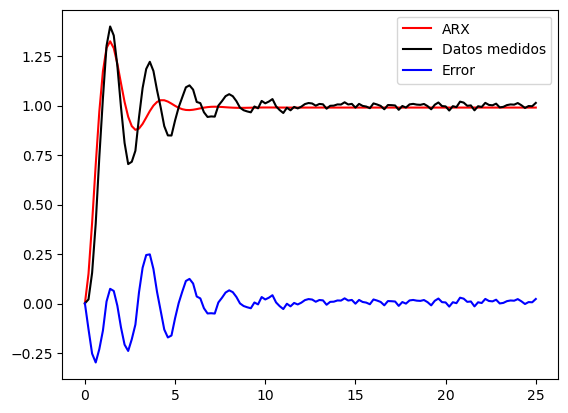

In [9]:
## Definiendo la función de transferencia estimada ARX
_,ye = control.step_response(G_e,t)

## Ganancia de ajuste
k = 1;
ye = k*ye

## Señal de error estimado
e = yn-ye

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['ARX','Datos medidos','Error'])

## Planteando el nuevo regresor

**Paso 5:** Se va propone un nuevo regresor que incluya la señal de error estimada en el paso anterior

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3],e[k-1],e[k-2],e[k-3]]$$

In [10]:
e_1 = np.zeros(N)
e_2 = np.zeros(N)
e_3 = np.zeros(N)
ye_1 = np.zeros(N)
ye_2 = np.zeros(N)
ye_3 = np.zeros(N)

for k in range(1,N):
    e_1[k]=e[k-1]
    ye_1[k]=ye[k-1]
for k in range(2,N):
    e_2[k]=e[k-2]
    ye_2[k]=ye[k-2]
for k in range(3,N):
    e_3[k]=e[k-3]
    ye_3[k]=ye[k-3]

## Creación del vector phi segunda estimación
phi2 = np.array([-y_1,-y_2,-y_3,u_1,u_2,e_1]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

Am = np.dot(phi2.T,phi2) + alpha*np.eye(len(np.dot(phi2.T,phi2)))
theta2 = np.dot(np.linalg.inv(Am),np.dot(phi2.T,yn))
theta2

array([-1.50291691,  0.61058917,  0.07851975,  0.01967039,  0.16522559,
       -0.10760593])

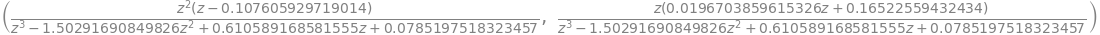

In [11]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A

## Construir los polinomios A(z) y B(z)
A = 1 + theta2[0]*z**-1 + theta2[1]*z**-2+ theta2[2]*z**-3  
B = theta2[3]*z**-1 + theta2[4]*z**-2 
C = 1 + theta2[5]*z**-1 
G = (B/A).simplify()
H = (C/A).simplify()
H, G

TransferFunction(array([0.01967039, 0.16522559, 0.        ]), array([ 1.        , -1.50291691,  0.61058917,  0.07851975]), 0.2)

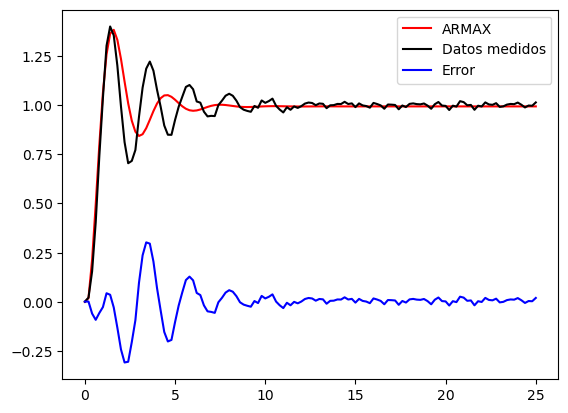

In [12]:
## Armando la función de transferencia estimada con los parámetros hallados
G2 = control.tf([theta2[3],theta2[4],0],[1,theta2[0],theta2[1],theta2[2]],dt)

## Se determina la respuesta estimada al escalón
_,y2 = control.step_response(G2,t)

e2 = yn-y2

plt.plot(t,y2,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e2,color = 'blue')

plt.legend(['ARMAX','Datos medidos','Error']);
G2

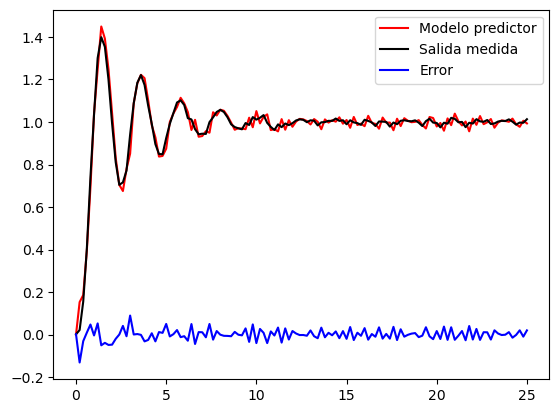

In [13]:
## Armando la función estimada con los parámetros hallados y usando 
## la fórmula del predictor.

yf = np.dot(_phi,theta)

e3 = yn - yf
plt.plot(t,yf,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e3,color = 'blue')
plt.legend(['Modelo predictor','Salida medida','Error'])

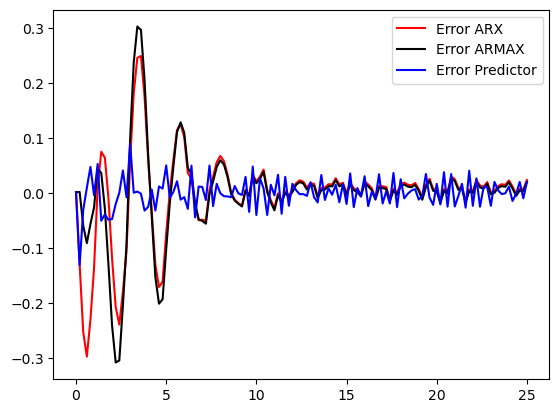

In [14]:
plt.plot(t,e,color = 'red')
plt.plot(t,e2,color = 'black')
plt.plot(t,e3,color = 'blue')
plt.legend(['Error ARX','Error ARMAX','Error Predictor'])